### TODO

- Find the right way to turn the solution into integers

In [225]:
from random import randint
import sys

import numpy as np
import scipy.optimize as optimize
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%xmode plain

def init_simulation(num_nodes, 
                    num_days, 
                    icu_capacities = None, 
                    transport_capacities = None, 
                    ini_path = None, 
                    demand_min = 2, 
                    demand_max = 10):
    if ini_path:
        print("you can also upload an .ini file")
        raise NotImplemented
    else:
        demand = []
        for node in range(num_nodes):
            demand.append(list(np.random.randint(demand_min, demand_max, size = num_days)))

    return icu_capacities, transport_capacities, demand


def calculate_outgoing(array,day,node):
    return sum(array[day][node])


def calculate_incoming(array,day,node):
    total_outgoing = 0
    for n in range(num_nodes):
        total_outgoing = total_outgoing + array[day][n][node]
    return total_outgoing


def demand_day_node_raw(node_capacity, demand_day, left_day, received_day, demand_previous_days, left_previous_days, received_previous_days):
    return demand_day - left_day + received_day+ min(demand_previous_days-left_previous_days+received_previous_days, node_capacity)


def demand_day_node(movements,day,node):
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    total_received_patients = 0
    total_outbound_patients = 0
    accumulated_demand = 0
    for d in range(day+1):
        total_received_patients = total_received_patients + calculate_incoming(movements_res,d,node)
        total_outbound_patients = total_outbound_patients + calculate_outgoing(movements_res,d,node)
    accumulated_demand = sum(demands[node][:day])
    
    demand = max(0, demand_day_node_raw(node_capacities[node],demands[node][day], 
                                        calculate_outgoing(movements_res,day,node), calculate_incoming(movements_res,day,node),
                                        accumulated_demand, total_outbound_patients, total_received_patients                
                ))
    return demand


def calc_total_unnatended(movements):
    total = 0
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    for node in range(num_nodes):
        for day in range(num_days):
            unnatended_not_attended = max(0, demand_day_node(movements,day,node) - node_capacities[node])
            unnant_because_transp = penalization_transport*movements_res[day].sum()
            total = total + unnatended_not_attended + unnant_because_transp
    return total


def outgoing_list(movements):
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    outgoing_list = list()
    for day in range(num_days):
        for node in range(num_nodes):
            outgoing_list.append(calculate_outgoing(movements_res,day,node))
    return outgoing_list

def generate_bounds():
    outgoing_list = list()
    for day in range(num_days):
        for outgoing_node in range(num_nodes):
            for incoming_node in range(num_nodes):
                outgoing_list.append((0,transport_capacities[outgoing_node]))
    return outgoing_list

def f_cons(node_id, day):
    return lambda x: transport_capacities[node_id] - calculate_outgoing(np.reshape(x,(num_days,num_nodes,num_nodes)),day ,node_id)


def split_n(num, num_nodes):
    #TODO this function is not truly random
    pieces = []
    for idx in range(num_nodes-1):
        pieces.append(randint(1,num-sum(pieces)-num_nodes+idx))

    pieces.append(num-sum(pieces))
    return pieces

def return_solution_info(movements,icu_capacities,demands):
    occupancy = []
    unattended = []
    for node in range(num_nodes):
        occupancy_list_temp = []
        unattended_list_temp = []
        for day in range(num_days):
            occupancy_temp = demand_day_node(movements,day,node)
            unattended_temp = max(0, occupancy_temp - icu_capacities[node])
            occupancy_list_temp.append(occupancy_temp)
            unattended_list_temp.append(unattended_temp)
        occupancy.append(occupancy_list_temp)
        unattended.append(unattended_list_temp)
    return occupancy, unattended

Exception reporting mode: Plain


In [226]:
51.543321, -0.178196, 51,49, -0.079

(51.543321, -0.178196, 51, 49, -0.079)

In [227]:
region_hospitals = (pd.read_csv("../hospitalData_beds.csv")
#                            .query("51.19 < Latitude < 51.543321 & -0.18 < Longitude < -0.07")
                           .query("54 < Latitude < 56 & -2.5 < Longitude < -0.5")
                            [["OrgName", "Latitude", "Longitude", "Genera_Acute_beds_open_night", "Total_ICU_beds"]]
                          )
region_hospitals

,OrgName,Latitude,Longitude,Genera_Acute_beds_open_night,Total_ICU_beds
143,SOUTH TYNESIDE AND SUNDERLAND NHS FOUNDATION T...,54.966625,-1.501260,1045,46
146,HARROGATE AND DISTRICT NHS FOUNDATION TRUST,54.344749,-1.432177,307,13
155,GATESHEAD HEALTH NHS FOUNDATION TRUST,54.946396,-1.659453,476,21
157,THE NEWCASTLE UPON TYNE HOSPITALS NHS FOUNDATI...,54.980217,-1.618840,1487,65
158,NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST,55.074070,-1.569669,841,37
159,SOUTH TEES HOSPITALS NHS FOUNDATION TRUST,54.404900,-1.738327,862,38
160,NORTH TEES AND HARTLEPOOL NHS FOUNDATION TRUST,54.582859,-1.347565,556,24
167,COUNTY DURHAM AND DARLINGTON NHS FOUNDATION TRUST,54.790741,-1.592397,852,37


In [230]:
region_hospitals["transport_capacity"] = 30
penalization_transport = 0
num_days = 5
num_nodes = region_hospitals.shape[0]

node_capacities, transport_capacities, demands = init_simulation(num_nodes, 
                                                                 num_days, 
                                                                 icu_capacities=london_region_hospitals["Total_ICU_beds"].values,
                                                                 transport_capacities=london_region_hospitals["transport_capacity"].values, 
                                                                 demand_min = 5, demand_max = 20)
print(f"""Randomly generated
{num_days} days, {num_nodes} hospitals
ICU capacities of hospitals: {node_capacities}
Daily transport capacities: {transport_capacities}, 
Daily simulated demand (from uniform distrution): 
{demands}""")

Randomly generated
5 days, 8 hospitals
ICU capacities of hospitals: [46 20  0 35 18 33 46 31]
Daily transport capacities: [30 30 30 30 30 30 30 30], 
Daily simulated demand (from uniform distrution): 
[[11, 19, 9, 8, 8], [8, 11, 17, 13, 5], [8, 17, 11, 16, 9], [9, 16, 19, 16, 17], [14, 9, 9, 19, 17], [14, 14, 16, 14, 14], [10, 18, 19, 11, 7], [13, 16, 18, 5, 8]]


In [231]:
#define constraints
cons = []
for node in range(num_nodes):
    for day in range(num_days):
        cons.append({'type': 'ineq', 'fun': f_cons(node,day)})

        
#no movement matrix, the base for generating random ones and one of the ones to test as init matrix 
no_movement = np.array([[[0]*num_nodes]*num_nodes]*num_days)

In [232]:
def random_init(knockdown_days = False, movement_intensity = 1, random_intensity = False, prior_matrix = np.array([])): 
    random_movement = prior_matrix.copy() if prior_matrix.any() else no_movement.copy()
    #if knockdown days is active, behave like a dropdown NN layer and drop half of the days movements
    active_days = np.random.choice([1,0], size=num_days) if knockdown_days else [1]*num_days
    for day in range(num_days):
        if active_days[day]:
            for node_x in range(num_nodes):
                movement_intensity = np.random.uniform() if random_intensity else movement_intensity
                #splits a number in a list of numbers pseudo randomly
                split_nodes = split_n(max(num_nodes+1, 
                                          np.ceil(transport_capacities[node_x]*movement_intensity)), 
                                      num_nodes)
                for node_y in range(num_nodes):
                    if node_x != node_y: 
                        if np.random.choice([0,1]): #allow numbers to decrease too
                            random_movement[day, node_x, node_y] += split_nodes[node_y]
                        else: 
                            random_movement[day, node_x, node_y] -= split_nodes[node_y]
                            random_movement[day, node_x, node_y] = max(0, random_movement[day, node_x, node_y])
                    
    return random_movement

### The main loop that generates random init matrices

In [247]:
%%time

#parameters to minimize
min_unnatended = sys.maxsize
best_result = None
result_matrix = None
#iterate through low to high intensity movement simulation
steps = []
knockdown = True
win_init_matrix = no_movement.copy()
iterations = 100
movement_intensity = 0.5
miss = 0
candidates = []
bounds_movement = generate_bounds()
for i in range(iterations):
    print(f"i:{i} intensity: {movement_intensity:.2f} knockdown: {knockdown} ", end="")

    if movement_intensity < 0.1 or miss >= 25:
        miss = 0
        #if there are candidates, try those first with reasonable parameters
        if candidates:
            print(f"using candidate from {len(candidates)} candidates list")
            movement = candidates.pop() 
            movement_intensity = 0.5
            knockdown = True
            miss = 0
        else:
            #otherwise go all-in
            print("going into full evolution", end="")
            movement = random_init(False, 1, prior_matrix=win_init_matrix)
    else:
        movement = random_init(knockdown, movement_intensity, prior_matrix=win_init_matrix)
        
        result = optimize.minimize(calc_total_unnatended, 
                                   movement, 
                                   method='SLSQP', 
                                   constraints=cons, 
                                   bounds=bounds_movement)

        current_unnatended = calc_total_unnatended(np.rint(result.x))
        print(f"Result:{current_unnatended:.0f}", end="")
        steps.append([movement_intensity, knockdown, current_unnatended])
        if min_unnatended == current_unnatended:
            print(" <--saving!", end="")        
            candidates.append(movement)
        elif min_unnatended > current_unnatended:
            knockdown = True
            miss = 0
            movement_intensity *= 0.9
            movement_intensity = min(0.5, movement_intensity)
            candidates = []
            print(" <--best!", end="")
            min_unnatended = int(current_unnatended)
            best_result = result
            result_matrix = np.reshape(np.rint(result.x),(num_days,num_nodes,num_nodes))
            win_init_matrix = movement
        else:
            movement_intensity = min(1, movement_intensity*1.05)
            miss += 1

    print("")
        
print("\nDone")

i:0 intensity: 0.50 knockdown: True Result:242 <--best!
i:1 intensity: 0.45 knockdown: True Result:245
i:2 intensity: 0.47 knockdown: True Result:247
i:3 intensity: 0.50 knockdown: True Result:245
i:4 intensity: 0.52 knockdown: True Result:234 <--best!
i:5 intensity: 0.47 knockdown: True Result:248
i:6 intensity: 0.49 knockdown: True Result:229 <--best!
i:7 intensity: 0.44 knockdown: True Result:231
i:8 intensity: 0.47 knockdown: True Result:229 <--saving!
i:9 intensity: 0.47 knockdown: True Result:240
i:10 intensity: 0.49 knockdown: True Result:232
i:11 intensity: 0.51 knockdown: True Result:246
i:12 intensity: 0.54 knockdown: True Result:248
i:13 intensity: 0.57 knockdown: True Result:244
i:14 intensity: 0.59 knockdown: True Result:239
i:15 intensity: 0.62 knockdown: True Result:249
i:16 intensity: 0.65 knockdown: True Result:242
i:17 intensity: 0.69 knockdown: True Result:240
i:18 intensity: 0.72 knockdown: True Result:241
i:19 intensity: 0.76 knockdown: True Result:239
i:20 intensi

KeyboardInterrupt: 

### These are the unnatended that we get with inaction

In [248]:
calc_total_unnatended(no_movement)

283

### This is the best result found

In [249]:
min_unnatended

226

### This the movement matrix

In [250]:
result_matrix

array([[[  0.,   1.,   1.,   0.,   0.,   2.,   2.,   2.],
        [  4.,   0.,   2.,   0.,   0.,   3.,   3.,   3.],
        [  8.,   2.,   0.,   0.,   0.,   2.,   2.,   3.],
        [  9.,   3.,   4.,   0.,   0.,   4.,   4.,   5.],
        [  4.,   3.,   4.,   2.,   0.,   4.,   6.,   6.],
        [  0.,   5.,   0.,   0.,   0.,   0.,   0.,   2.],
        [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.],
        [  1.,   6.,   1.,   0.,   0.,   3.,   2.,   0.]],

       [[  0.,   1.,   1.,   2.,   1.,   1.,   1.,   1.],
        [  1.,   0.,   1.,   2.,   1.,   1.,   1.,   1.],
        [  2.,   2.,   0.,   3.,   2.,   2.,   2.,   2.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   0.,   1.,   2.,   0.,   1.,   1.,   0.],
        [  1.,   1.,   1.,   2.,   2.,   0.,   1.,   1.],
        [  1.,   1.,   1.,   2.,   2.,   1.,   0.,   1.],
        [  1.,   1.,   1.,   3.,   1.,   1.,   2.,   0.]],

       [[  0.,   1.,   4.,   1.,   3.,   0.,   1.,   1.],
        [ 

### These are the stats day by day

In [251]:
occupancy, unattended = return_solution_info(result_matrix,node_capacities,demands)

In [252]:
occupancy

[[47.0, 46.0, 85.0, 89.0, 53.0],
 [18.0, 20.0, 19.0, 38.0, 27.0],
 [0, 3.0, 13.0, 7.0, 14.0],
 [0, 30.0, 37.0, 33.0, 33.0],
 [0, 0, 20.0, 18.0, 16.0],
 [36.0, 35.0, 31.0, 38.0, 54.0],
 [44.0, 43.0, 45.0, 41.0, 64.0],
 [31.0, 30.0, 30.0, 42.0, 41.0]]

In [253]:
unattended

[[1.0, 0, 39.0, 43.0, 7.0],
 [0, 0, 0, 18.0, 7.0],
 [0, 3.0, 13.0, 7.0, 14.0],
 [0, 0, 2.0, 0, 0],
 [0, 0, 2.0, 0, 0],
 [3.0, 2.0, 0, 5.0, 21.0],
 [0, 0, 0, 0, 18.0],
 [0, 0, 0, 11.0, 10.0]]

In [254]:
df = pd.DataFrame(steps)
df.columns = ["movement_intensity", "knockdown", "result"]

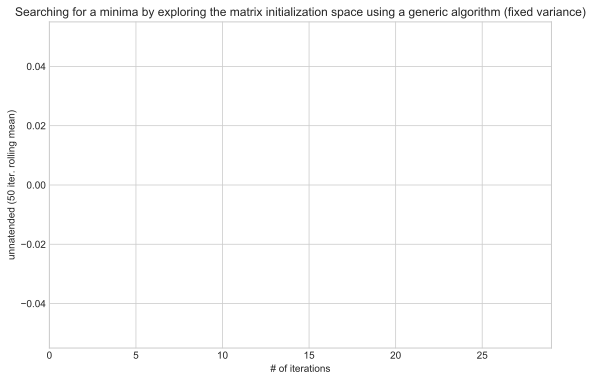

In [255]:
df.result.rolling(50).mean().plot(figsize=(9, 6), title="Searching for a minima by exploring the matrix initialization space using a generic algorithm (fixed variance)")
plt.xlabel("# of iterations")
plt.ylabel("unnatended (50 iter. rolling mean)");

In [256]:
for node in range(num_nodes):
    for day in range(num_days):
        print(f'Node: {node}, Day: {day}, Demand: {demand_day_node(np.rint(result.x),day,node)}')

Node: 0, Day: 0, Demand: 47.0
Node: 0, Day: 1, Demand: 46.0
Node: 0, Day: 2, Demand: 85.0
Node: 0, Day: 3, Demand: 89.0
Node: 0, Day: 4, Demand: 53.0
Node: 1, Day: 0, Demand: 18.0
Node: 1, Day: 1, Demand: 20.0
Node: 1, Day: 2, Demand: 19.0
Node: 1, Day: 3, Demand: 38.0
Node: 1, Day: 4, Demand: 27.0
Node: 2, Day: 0, Demand: 0
Node: 2, Day: 1, Demand: 3.0
Node: 2, Day: 2, Demand: 13.0
Node: 2, Day: 3, Demand: 7.0
Node: 2, Day: 4, Demand: 14.0
Node: 3, Day: 0, Demand: 0
Node: 3, Day: 1, Demand: 30.0
Node: 3, Day: 2, Demand: 37.0
Node: 3, Day: 3, Demand: 33.0
Node: 3, Day: 4, Demand: 33.0
Node: 4, Day: 0, Demand: 0
Node: 4, Day: 1, Demand: 0
Node: 4, Day: 2, Demand: 20.0
Node: 4, Day: 3, Demand: 18.0
Node: 4, Day: 4, Demand: 16.0
Node: 5, Day: 0, Demand: 36.0
Node: 5, Day: 1, Demand: 35.0
Node: 5, Day: 2, Demand: 31.0
Node: 5, Day: 3, Demand: 38.0
Node: 5, Day: 4, Demand: 54.0
Node: 6, Day: 0, Demand: 44.0
Node: 6, Day: 1, Demand: 43.0
Node: 6, Day: 2, Demand: 45.0
Node: 6, Day: 3, Demand:

# Visualisation/Animation

In [298]:
import PIL.Image as Image 
import numpy as np

im = Image.open('UK.jpg')
# im.shape
pix = np.array(im)

# hospitalbeds = pd.read_csv('../hospitalData_beds.csv')
# del hospitalbeds

t = 3
ref_locations = np.zeros((region_hospitals.shape[0],2))
ref_locations[:,0] = region_hospitals.Longitude.values
ref_locations[:,1] = region_hospitals.Latitude.values
ref_capacities = region_hospitals['Total_ICU_beds'].values

usage = np.array(occupancy)[:,t]
transfers = result_matrix[t]

usage

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, Patch
import itertools

def plot_hospital(xy, capacity, usage, width=1, height=1, maxCapacity=None, minCapacity=None, ax=None):
    if ax is None:
        ax = plt.gca()
#     print( xy, capacity, usage, width, height)

    
    maxHeight = height
    h = height*(usage/capacity)
    if usage > capacity:
        overUsage = usage-capacity
        usage = capacity
    else:
        overUsage = 0
    
    
    if maxCapacity is not None:
        if minCapacity is not None:
            maxHeight = height*(max(minCapacity,capacity)/maxCapacity) # scale each hospital differently
            h = maxHeight*(usage/capacity)
        else:
            maxHeight = height*(capacity/maxCapacity) # scale each hospital differently
            h = maxHeight*(usage/capacity)
    
    
    r1 = Rectangle((xy[0]-width/2, xy[1]), width, h)
    pc = PatchCollection([r1], facecolor='yellow', alpha=.8, edgecolor='yellow') # used
    
    ax.add_collection(pc)

    r2 = Rectangle((xy[0]-width/2, xy[1]+h), width, maxHeight-h)
    pc = PatchCollection([r2], facecolor='blue', alpha=.8, edgecolor='blue') # free
    
    ax.add_collection(pc)

    if overUsage > 0:
        r3 = Rectangle((xy[0]-width/2, xy[1]+maxHeight), width, (overUsage/capacity)*maxHeight)
        pc = PatchCollection([r3], facecolor='red', alpha=.8, edgecolor='red') # free

        ax.add_collection(pc)
    
    
def plot_hospitals(ref_locations, ref_capacities, ref_usage, width, height, maxCapacity=None, minCapacity=None, ax=None):
    if ax is None:
        ax = plt.gca()

    for h in range(ref_locations.shape[0]):
        if ref_capacities[h] <= 0:
            continue
        plot_hospital(*(list(zip(*[ref_locations, ref_capacities, ref_usage]))[h]), width, height, maxCapacity, minCapacity,ax=ax)

        
def plot_transfers(ref_locations, transfers, ax=None):
    if ax is None:
        ax = plt.gca()

    arrowWidthPerTransfer = 0.02
    for (i, j) in itertools.product(range(transfers.shape[0]), range(transfers.shape[1])):
        if i != j and transfers[i,j] > 0:
#             print(i, j, ref_locations[i],  ref_locations[j])
            ax.annotate('', 
                        xy=ref_locations[i],
                        xytext=ref_locations[j],
                        arrowprops=
                        dict(
                            facecolor='black'
                            , shrink=0.05
                            , alpha=.5
                            ,width = arrowWidthPerTransfer*transfers[i,j]
                            ,headwidth = max(3*arrowWidthPerTransfer*transfers[i,j],5)
                            ))

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

def plot_transfers_timed(ref_locations, transfers, curStep, maxSteps, ax=None):
    if ax is None:
        ax = plt.gca()

    blobSizePerPerson = 0.002
    
    patches = []
    for (i, j) in itertools.product(range(transfers.shape[0]), range(transfers.shape[1])):
        if i != j and transfers[i,j] > 0:
#             print(i, j, ref_locations[i],  ref_locations[j])
            orig = ref_locations[j]
            dest = ref_locations[i]
            blobPos = orig + (dest-orig)*(curStep/maxSteps)
            if curStep == 0:
                trailPos = blobPos
            else:
                trailPos = orig + (dest-orig)*((curStep-1)/maxSteps)
            
#             print(blobPos)
            oneBlob = circle = mpatches.Circle(blobPos, blobSizePerPerson*transfers[i,j], ec="none")
            patches.append(circle)
        
#             trail = mpatches.Line2D(blobPos[0],blobPos[1], trailPos[0], trailPos[1])
#             patches.append(circle)
        
    collection = PatchCollection(patches, facecolor='blue', alpha=.8, edgecolor='black')
    ax.add_collection(collection)
    

[46 13 21 65 37 38 24 37] [ 46.  20.   3.  30.   0.  35.  43.  30.] [  0.  -7.  18.  35.  37.   3. -19.   7.]


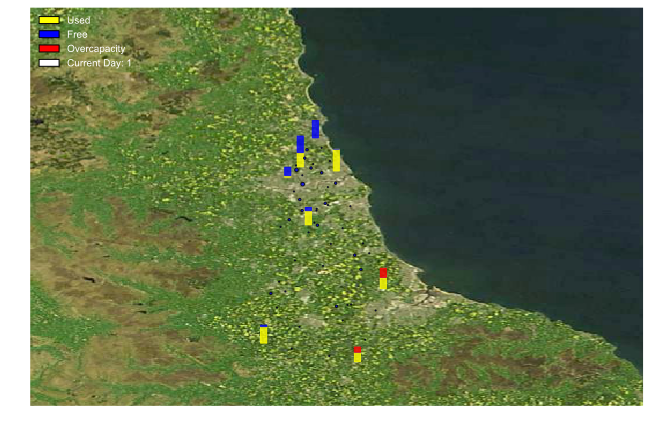

In [299]:
UKMapBorders = [-11., 2.559843, 49.504057, 59.386039]

# for t in range(num_days):
if True:
    t = 1
    usage = np.array(occupancy)[:,t]
    transfers = result_matrix[t]

    print(ref_capacities, usage, ref_capacities-usage)
    
    plt.figure(figsize=(11,9))
    ax = plt.gca()
    ax.imshow(pix, extent=UKMapBorders) #(-8,16,-9,18))
    ax.axis('off')
    # ax.scatter(hospitals.Longitude, hospitals.Latitude, c='r')

    # ax.scatter(ref_locations[:,0], ref_locations[:,1], c='k')
    plot_hospitals(ref_locations, ref_capacities, usage, .02, .10, maxCapacity=max(ref_capacities), minCapacity=20, ax=ax)
#     plot_transfers(ref_locations, transfers, ax=ax)
    plot_transfers_timed(ref_locations, transfers, 3,10,ax=ax)
    ax.set_xlim(-2.5,-0.5)
    ax.set_ylim(54.2,55.5)



    legend_elements = [Patch(facecolor='yellow', edgecolor='k',label='Used')
                      ,Patch(facecolor='blue', edgecolor='k',label='Free')
                      ,Patch(facecolor='red', edgecolor='k',label='Overcapacity')
                      ,Patch(facecolor='White', edgecolor='k',label=f'Current Day: {t}')
                      ]

    # Create the figure
    leg = ax.legend(handles=legend_elements, loc='upper left')

    # colors = ['yellow', 'blue', 'red']
    colors = ['white', 'white', 'white', 'white']
    for color,text in zip(colors,leg.get_texts()):
        text.set_color(color)

In [300]:
transfers.shape

(8, 8)

1
1 30
2
2 30
3
3 30
4
4 30
5
5 30
6
6 30
7
7 30
8
8 30
9
9 30
10
10 30
11
11 30
12
12 30
13
13 30
14
14 30
15
15 30
16
16 30
17
17 30
18
18 30
19
19 30
20
20 30
21
21 30
22
22 30
23
23 30
24
24 30
25
25 30
26
26 30
27
27 30
28
28 30
29
29 30
30
0 30
31
1 30
32
2 30
33
3 30
34
4 30
35
5 30
36
6 30
37
7 30
38
8 30
39
9 30
40
10 30
41
11 30
42
12 30
43
13 30
44
14 30
45
15 30
46
16 30
47
17 30
48
18 30
49
19 30
50
20 30
51
21 30
52
22 30
53
23 30
54
24 30
55
25 30
56
26 30
57
27 30
58
28 30
59
29 30
60
0 30
61
1 30
62
2 30
63
3 30
64
4 30
65
5 30
66
6 30
67
7 30
68
8 30
69
9 30
70
10 30
71
11 30
72
12 30
73
13 30
74
14 30
75
15 30
76
16 30
77
17 30
78
18 30
79
19 30
80
20 30
81
21 30
82
22 30
83
23 30
84
24 30
85
25 30
86
26 30
87
27 30
88
28 30
89
29 30
90
0 30
91
1 30
92
2 30
93
3 30
94
4 30
95
5 30
96
6 30
97
7 30
98
8 30
99
9 30
100
10 30
101
11 30
102
12 30
103
13 30
104
14 30
105
15 30
106
16 30
107
17 30
108
18 30
109
19 30
110
20 30
111
21 30
112
22 30
113
23 30
114
24 30
115
25 

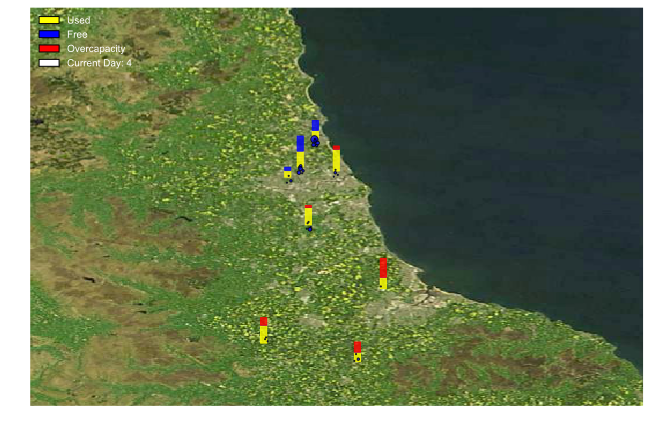

In [301]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


ref_locations = np.zeros((region_hospitals.shape[0],2))
ref_locations[:,0] = region_hospitals.Longitude.values
ref_locations[:,1] = region_hospitals.Latitude.values
ref_capacities = region_hospitals['Total_ICU_beds'].values




def animinit():
    return []

def animBaseBackground(version=0):
    ax = plt.gca()
    ax.cla()
    ax.imshow(pix, extent=UKMapBorders) #(-8,16,-9,18))
    ax.axis('off')
    ax.set_xlim(-2.5,-0.5)
    ax.set_ylim(54.2,55.5)
    return

def animupdate(frame):
#     plt.clf()
    animBaseBackground()
    r = next(fi)
    return []

def frameIterator(invStep = 4):
    step = 1/invStep
    i = 0
    while True:
        i = i+1
        print(i)
        t = i//invStep
        usage = np.array(occupancy)[:,t]
        transfers = result_matrix[t]
        
        plot_hospitals(ref_locations, ref_capacities, usage, .02, .10, maxCapacity=max(ref_capacities), minCapacity=20, ax=ax)
        print(i%invStep, invStep)
        plot_transfers_timed(ref_locations, transfers, i%invStep, invStep,ax=ax)
        
        # plot_transfers(ref_locations, transfers, ax=ax)
        legend_elements = [Patch(facecolor='yellow', edgecolor='k',label='Used')
                          ,Patch(facecolor='blue', edgecolor='k',label='Free')
                          ,Patch(facecolor='red', edgecolor='k',label='Overcapacity')
                          ,Patch(facecolor='White', edgecolor='k',label=f'Current Day: {t}')
                          ]

        # Create the figure
        leg = ax.legend(handles=legend_elements, loc='upper left')

        # colors = ['yellow', 'blue', 'red']
        colors = ['white', 'white', 'white', 'white']
        for color,text in zip(colors,leg.get_texts()):
            text.set_color(color)
        
        yield    

# fps = 2

fig = plt.figure(figsize=(11,9))
ax = plt.gca()

fps = 30
fi = frameIterator(fps)

numFrames = num_days*fps-1
ani = FuncAnimation(fig, animupdate, frames=np.arange(numFrames), init_func=animinit, blit=True)
# ani.save('testAni1.mp4')
HTML(ani.to_html5_video())


100


IndexError: index 5 is out of bounds for axis 1 with size 5

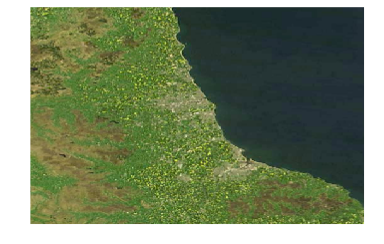

In [293]:
ani.save('testAni1.mp4')